In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
sys.path.append('..')

In [18]:
import cv2
from tqdm import tqdm

from lib.data import load_extracted_samples, load_extracted_sample
from lib.details_ocr import extract_lines_ocr, filter_detail_lines, split_detail_line
from lib.image_preprocessing import deskew_image
from lib.ocr import get_ocrs
from lib.util import display_image

In [19]:
samples = load_extracted_samples("only_ocr")
len(samples)

6294

In [20]:
# from lib.ocr import OCRParams, run_ocr_sample
# run_ocr_sample( load_extracted_sample("K37537400.pdf"), OCRParams(engine="paddleocr", deskew=True))

In [21]:
sample = load_extracted_sample("K37537400.pdf")
ocr = get_ocrs(sample)["paddleocr_deskew"]

page_index = 0
page_ocr = ocr[page_index]
image_path = sample["images"][page_index]
image = cv2.imread(image_path)
image = deskew_image(image)

In [22]:
sample

{'filename': 'K37537400.pdf',
 'size': 1959724,
 'pages': 2,
 'text': '',
 'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/K37537400.pdf/0.png',
  '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/K37537400.pdf/1.png']}

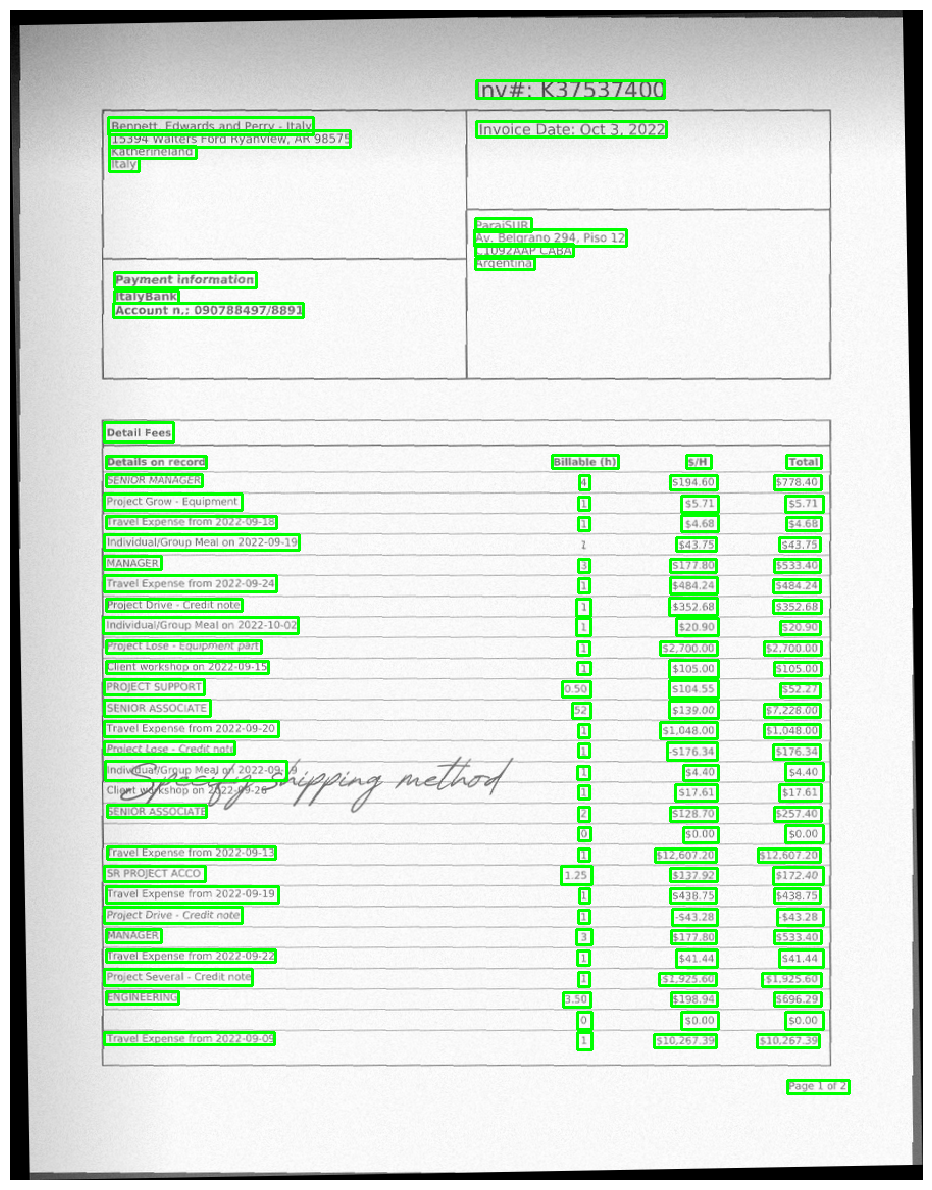

In [23]:
image_boxes = image.copy()

for box in page_ocr["boxes"]:
    cv2.rectangle(image_boxes, box["bounds"][0], box["bounds"][2], (0, 255, 0), 2)

display_image(image_boxes)

In [24]:
def display_lines(image, lines):
    img = image.copy()

    for boxes in lines:
        x_min = min(boxes, key=lambda k: k["bounds"][0][0])["bounds"][0][0]
        x_max = max(boxes, key=lambda k: k["bounds"][2][0])["bounds"][2][0]
        y_min = min(boxes, key=lambda k: k["bounds"][0][1])["bounds"][0][1]
        y_max = max(boxes, key=lambda k: k["bounds"][2][1])["bounds"][2][1]
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) # type: ignore

    display_image(img)

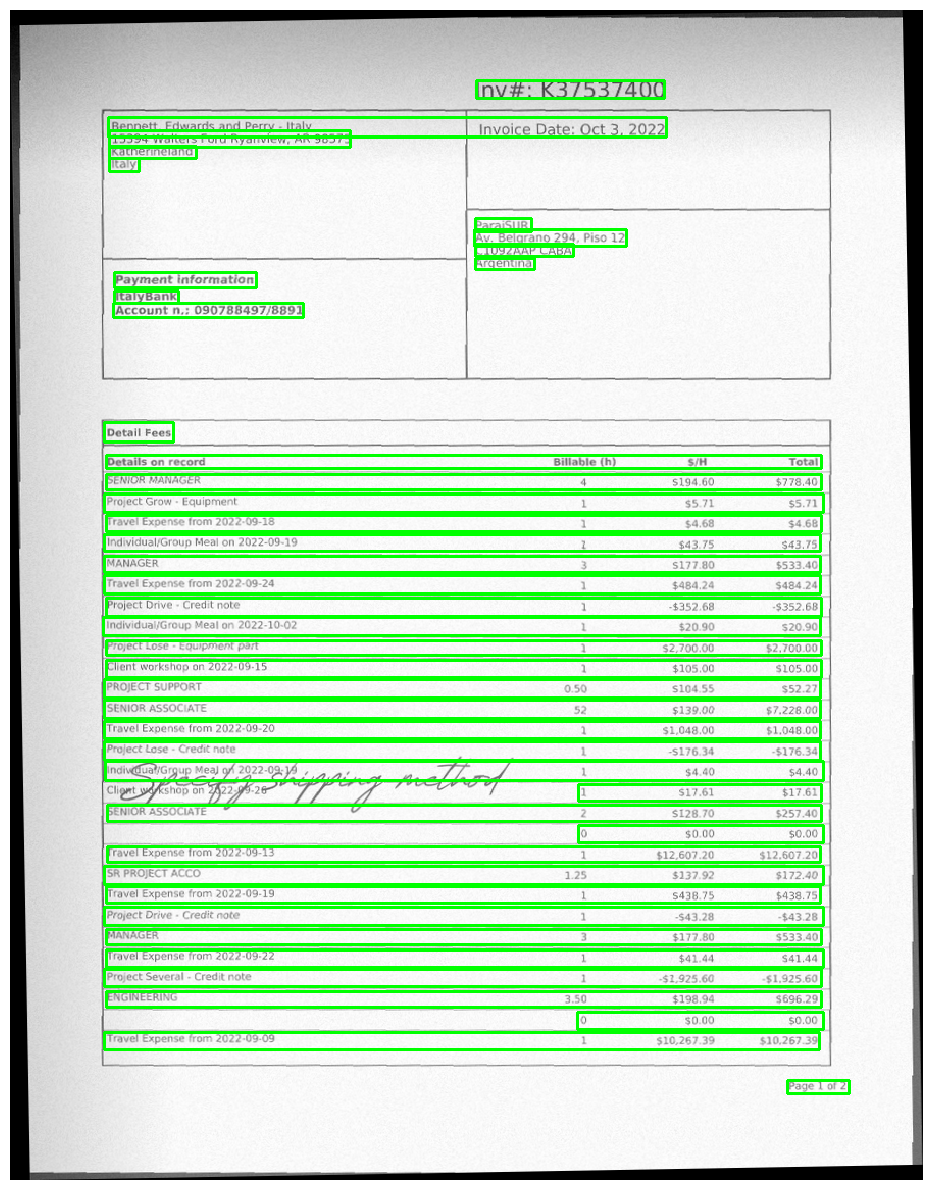

In [25]:
lines = extract_lines_ocr(page_ocr["boxes"])
display_lines(image, lines)

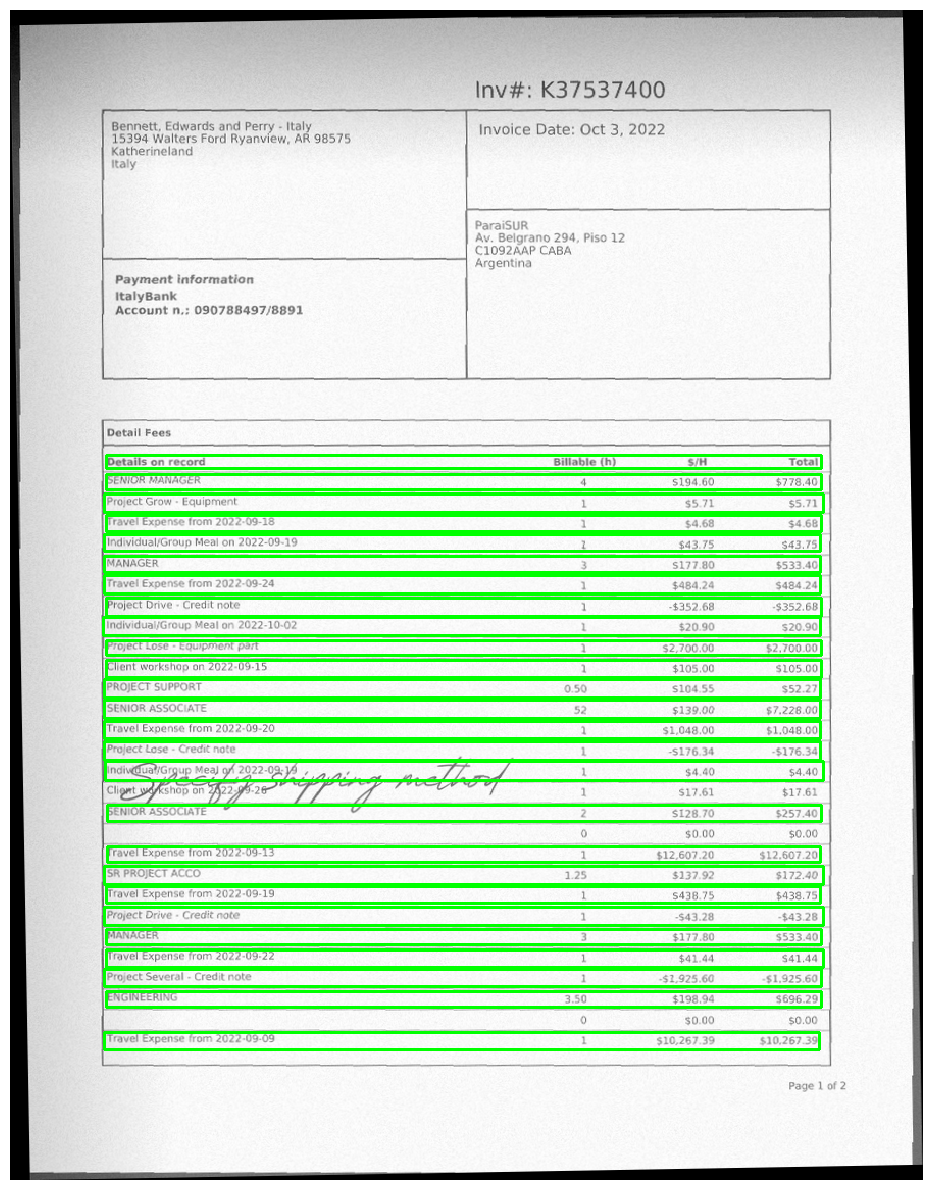

In [26]:
detail_lines = filter_detail_lines(lines)
display_lines(image, detail_lines)

In [27]:
[split_detail_line(line) for line in detail_lines]

[None,
 {'desc': 'SENIOR MANAGER 4 $194.60', 'total': 778.4, 'total_str': '$778.40'},
 {'desc': 'Project Grow-Equipment 1 $5.71',
  'total': 5.71,
  'total_str': '$5.71'},
 {'desc': 'Travel Expense from 2022-09-18 1 $4.68',
  'total': 4.68,
  'total_str': '$4.68'},
 {'desc': 'Individual/Group Meal on 2022-09-19 $43.75',
  'total': 43.75,
  'total_str': '$43.75'},
 {'desc': 'MANAGER 3 $177.80', 'total': 533.4, 'total_str': '$533.40'},
 {'desc': 'Travel Expense from 2022-09-24 1 $484.24',
  'total': 484.24,
  'total_str': '$484.24'},
 {'desc': 'Project Drive-Credit note 1 $352.68',
  'total': 352.68,
  'total_str': '$352.68'},
 {'desc': 'Individual/Group Meal on 2022-10-02 1 $20.90',
  'total': 20.9,
  'total_str': '$20.90'},
 {'desc': 'Project Lose-Equipment part 1 $2,700.00',
  'total': 2700.0,
  'total_str': '$2.700.00'},
 {'desc': 'Client workshop on 2022-09-15 1 $105.00',
  'total': 105.0,
  'total_str': '$105.00'},
 {'desc': 'PROJECT SUPPORT 0.50 $104.55',
  'total': 52.27,
  'tota

In [28]:
# calcular el % de None's que hay en promedio en los samples
none_avgs = []

for sample in tqdm(samples):
    ocrs = get_ocrs(sample)
    if "paddleocr_deskew" in ocrs:
        all_lines = []

        for page_ocr in ocrs["paddleocr_deskew"]:
            all_lines += extract_lines_ocr(page_ocr["boxes"])
        
        detail_lines = filter_detail_lines(all_lines)
        splitted_lines = [split_detail_line(line) for line in detail_lines]

        num_nones = sum([1 for line in splitted_lines if line is None])
        num_lines = len(splitted_lines)

        # print(sample, splitted_lines)
        none_avgs.append((sample, num_nones / num_lines))

100%|██████████| 6294/6294 [02:16<00:00, 46.12it/s]


In [29]:
# sort by avg
sorted(none_avgs, key=lambda x: -x[1])[:2]

[({'filename': 'Invoice (5213).pdf',
   'size': 1069162,
   'pages': 2,
   'text': '',
   'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Invoice (5213).pdf/0.png',
    '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Invoice (5213).pdf/1.png']},
  1.0),
 ({'filename': 'Email_Attachment_2023-03-20_6589.pdf',
   'size': 873801,
   'pages': 2,
   'text': '',
   'images': ['/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Email_Attachment_2023-03-20_6589.pdf/0.png',
    '/mnt/c/Users/mlomb/Desktop/ParaiSUR/data-extracted/Email_Attachment_2023-03-20_6589.pdf/1.png']},
  1.0)]

(array([1655., 2700., 1099.,  355.,  143.,   93.,   26.,   15.,   13.,
          12.,   11.,   17.,   18.,   19.,   15.,   19.,   12.,   12.,
          12.,   48.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

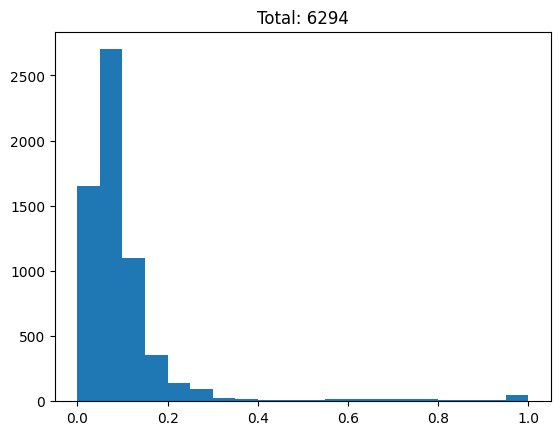

In [30]:
# plot avg distribution
import matplotlib.pyplot as plt

plt.title("Total: " + str(len(none_avgs)))
plt.hist([x[1] for x in none_avgs], bins=20, range=(0, 1))